In [38]:
import datalog  as dl
import pandas as pd
import numpy as np

def read_wpilog(filename):
    data = dl.wpilog_to_json(filename)
    df = pd.DataFrame(data)
    return df

df = read_wpilog('FRC_20230211_194425.wpilog')
# df = read_wpilog('FRC_20230211_194809.wpilog')
# Remove the standard data fields, only keeping our custom data.
df = df[df['name'].apply(lambda x: not x.startswith('NT:/') and x != 'NTConnection' and x != 'messages')]
df = df[df['name'].apply(lambda x: x not in ['old pose X', 'old pose Y', 'old pose heading'])]
# Verify we've got only what we need
df['name'].unique()


array(['pose X', 'pose Y', 'pose heading', 'llPose X', 'llPose Y',
       'llPose heading', 'used Lime Light', 'velocityX', 'velocityY',
       'velocityZ', 'target X', 'target Y', 'error X', 'error Y',
       'is notifier stopped', 'target heading'], dtype=object)

In [39]:
# Now we create a rownum column that will take every variable we're logging,
# group them together and internally sort that group by the timestamp value and
# create an increasing row number for each group.
# This in effect ranks the first target X witha rownum=1, the first target Y with a rownum=1
# and so on down the line of columns, then rownum=2 contains the second value for each variable.
df['rownum'] = df.sort_values(by='timestamp').groupby('name').cumcount() + 1

# Now for each rownum we create new columns that shows us the minimum, or
# first timestamp value in that rownum as well as max/last and the difference
# between them. If the time difference is too large (subjective) we might want to consider
# dropping an incomplete row of data or adjusting our technique for lining them up.
df['mints'] = df.groupby('rownum')['timestamp'].transform('min')
df['maxts'] = df.groupby('rownum')['timestamp'].transform('max')
df['avgts'] = df.groupby('rownum')['timestamp'].transform('mean')
df['diffts'] = df['maxts'] - df['mints']

# Look for the rows with the largest difference.
# (This is how I figured out we should drop messages from the data)
timecheck_df = df.sort_values(by='diffts', ascending=True)
timecheck_df.head()

,name,type,timestamp,value,rownum,mints,maxts,avgts,diffts
53944,pose Y,double,41.296867,29.999687,2023,41.296863,41.296885,41.296874,0.000022
53949,used Lime Light,boolean,41.296885,False,2023,41.296863,41.296885,41.296874,0.000022
53948,llPose heading,double,41.296881,169.933835,2023,41.296863,41.296885,41.296874,0.000022
53947,llPose Y,double,41.296877,46.718408,2023,41.296863,41.296885,41.296874,0.000022
53946,llPose X,double,41.296874,238.108054,2023,41.296863,41.296885,41.296874,0.000022


In [40]:
# Currently the df dataframe has a single 'name' column and a single 'value' column
# that is a mix of everything we're measuring. Here we take each value for 'name'
# (target X, target Y, etc.. ) and turn them into a column with ther row's 'value'
# as the value of the cell
pivot_df = df.pivot(index='rownum', columns='name', values='value')
pivot_df['pose error'] = (pivot_df['pose heading']-pivot_df['target heading']).abs()
pivot_df = pivot_df.merge(df[['mints', 'maxts', 'avgts', 'diffts', 'rownum']], on='rownum', how='left').drop_duplicates()
pivot_df.head()


,rownum,error X,error Y,is notifier stopped,llPose X,llPose Y,llPose heading,pose X,pose Y,pose heading,...,target heading,used Lime Light,velocityX,velocityY,velocityZ,pose error,mints,maxts,avgts,diffts
0,1,0.0,0.0,False,NaN,NaN,NaN,0.0,0.0,0.00061,...,180.0,False,0.0,0.0,0.278549,179.99939,2.243319,10.498615,6.886922,8.255296
16,2,-0.009353,0.000354,False,NaN,NaN,NaN,0.0,0.0,-0.001373,...,180.0,False,0.0,0.0,0.282135,180.001373,2.325929,10.550490,6.952223,8.224561
32,3,-0.289954,0.01098,False,NaN,NaN,NaN,0.0,0.0,-0.001373,...,180.0,False,0.0,0.0,0.283096,180.001373,2.329929,10.553233,6.955520,8.223304
48,4,-0.307632,0.01165,False,NaN,NaN,NaN,0.0,0.0,-0.001373,...,180.0,False,0.0,0.0,0.283096,180.001373,2.333857,10.555878,6.958677,8.222021
64,5,-0.326151,0.012351,False,NaN,NaN,NaN,0.0,0.0,-0.001373,...,180.0,False,0.0,0.0,0.283096,180.001373,2.337691,10.558842,6.961579,8.221151


In [41]:
# Look for where the limelight was used
ll = pivot_df.loc[pivot_df['used Lime Light'] == True]
print(f'Rows found: {len(ll.index)}')
ll

Rows found: 2


,rownum,error X,error Y,is notifier stopped,llPose X,llPose Y,llPose heading,pose X,pose Y,pose heading,...,target heading,used Lime Light,velocityX,velocityY,velocityZ,pose error,mints,maxts,avgts,diffts
8352,523,0.0,0.0,False,241.061339,37.055186,169.920848,226.841318,30.80523,173.181244,...,90.0,True,-0.031418,0.114716,0.001083,83.181244,11.297676,16.758531,14.364552,5.460855
8368,524,0.021553,-0.000904,False,241.061339,37.055186,169.920848,240.276855,37.096449,169.895671,...,90.0,True,-0.031418,0.114716,0.001083,79.895671,11.319004,16.768605,14.380322,5.449601


In [42]:
# Trim our original dataframe down to just the rownum and timestamp values
ts_df = df[['rownum', 'mints', 'maxts', 'avgts', 'diffts']]
ts_df = ts_df.drop_duplicates()

# Join the timestamp data back to our pivoted dataset so we've got that available in a single dataframe
# The ts_df dataframe is basically a spreadsheet with rownum and the timestamp values for each as the columns
# The pivot_df also contains the same rownum value, but it is already naturally its index
# and Panads joins on indexes without fuss, so we index the ts_df to the rownum column it has
# and let pandas join them up. Think of it like making two spreadsheets and copying and pasting
# them together and it works because they're ordered the same way with the same number of rows.
full_df = ts_df.set_index('rownum').join(pivot_df)

# Fill forward any NaN (null) values that are still in the data. This basically says to
# use the last known value for a column, like target X, if NaN was reported in this time slot
full_df = full_df.ffill()
# full_df

ValueError: columns overlap but no suffix specified: Index(['mints', 'maxts', 'avgts', 'diffts'], dtype='object')

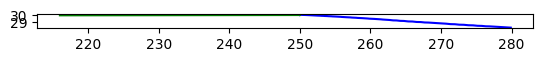

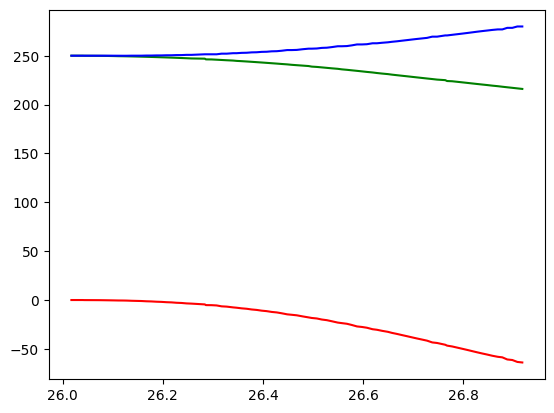

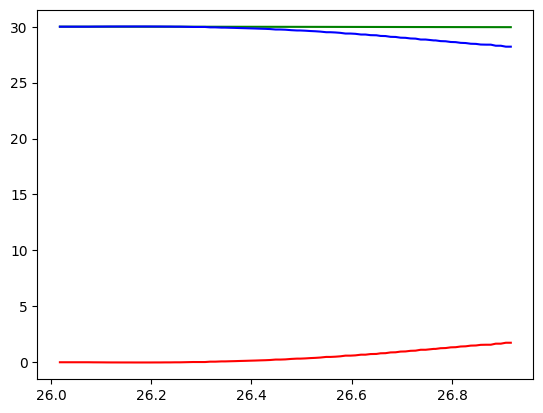

In [ ]:
import matplotlib.pyplot as plt

plt.plot(full_df['pose X'], full_df['pose Y'], c='b')
plt.plot(full_df['target X'], full_df['target Y'], c='g')
plt.gca().set_aspect(1)
plt.show()

#plt.plot(full_df['target X'], full_df['target Y'])
plt.plot(full_df['mints'], full_df['error X'], c='r')
plt.plot(full_df['mints'], full_df['target X'], c='g')
plt.plot(full_df['mints'], full_df['pose X'], c='b')
plt.show()

plt.plot(full_df['mints'], full_df['error Y'], c='r')
plt.plot(full_df['mints'], full_df['target Y'], c='g')
plt.plot(full_df['mints'], full_df['pose Y'], c='b')
plt.show()


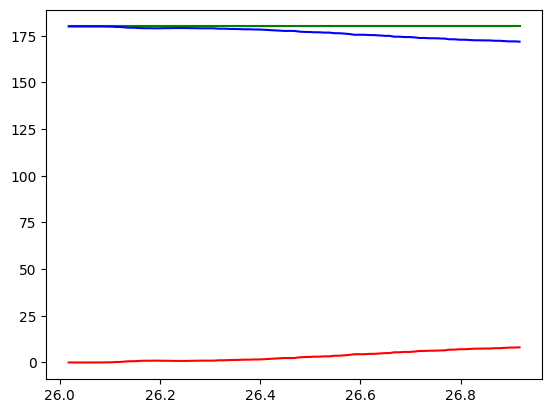

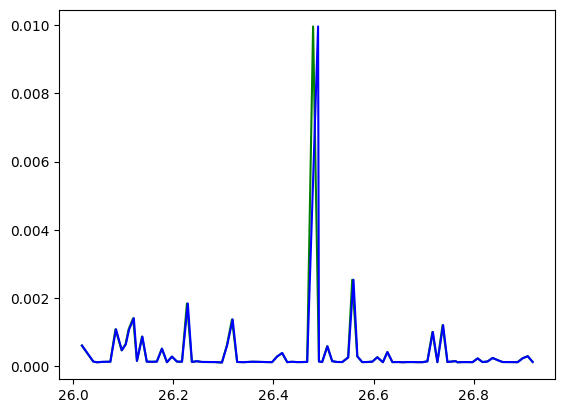

In [ ]:

plt.plot(full_df['mints'], full_df['pose error'], c='r')
plt.plot(full_df['mints'], full_df['target heading'], c='g')
plt.plot(full_df['mints'], full_df['pose heading'], c='b')
plt.show()
plt.plot(full_df['mints'], full_df['diffts'], c='g')
plt.plot(full_df['maxts'], full_df['diffts'], c='b')
plt.show()

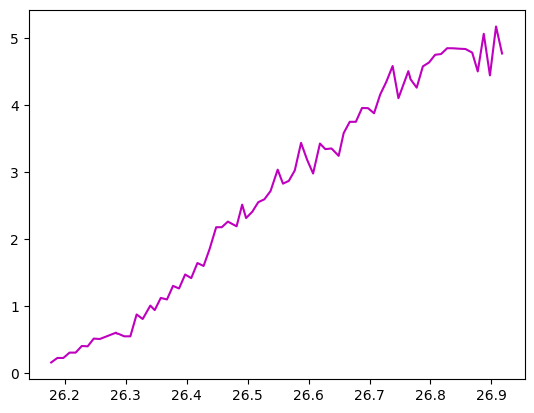

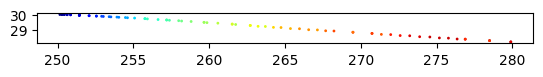

In [ ]:
tmpdf = full_df
tmpdf['deltaX'] = (tmpdf['pose X']-tmpdf['pose X'].shift(1)).abs()
tmpdf['deltaY'] = (tmpdf['pose Y']-tmpdf['pose Y'].shift(1)).abs()
tmpdf['distance'] = np.sqrt(tmpdf['deltaX']**2 + tmpdf['deltaY']**2)
tmpdf['velocity'] = tmpdf['distance']/(tmpdf['avgts']-tmpdf['avgts'].shift(1))
tmpdf['velocity_fps'] = tmpdf['velocity']/12
tmpdf['velocity_fps_avg'] = tmpdf['velocity_fps'].rolling(16).mean()

tmpdf['deltaVelocity'] = tmpdf.velocity - tmpdf.velocity.shift(1)
tmpdf['acceleration'] = tmpdf.deltaVelocity / (tmpdf.mints - tmpdf.mints.shift(1))  # In inches/sec/sec

plt.plot(tmpdf['avgts'], tmpdf['velocity_fps_avg'], c='m')
plt.show()

plt.scatter(tmpdf['pose X'], tmpdf['pose Y'], s=1, c=tmpdf.velocity_fps_avg, cmap='jet')
plt.gca().set_aspect(1)
plt.show()